In [17]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import datasets
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [23]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

In [24]:
class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
        self.min_samples_split=min_samples_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1],self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # check the stopping criteria
        if (depth>=self.max_depth or n_labels==1 or n_samples<self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_feats, self.n_features, replace=False)

        # find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)

        # create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold


    def _information_gain(self, y, X_column, threshold):
        # parent entropy
        parent_entropy = self._entropy(y)

        # create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        
        # calculate the weighted avg. entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
        

In [25]:
class RandomForest:
    def __init__(self, n_trees=10, max_depth=10, min_samples_split=2, n_feature=None):
        self.n_trees = n_trees
        self.max_depth=max_depth
        self.min_samples_split=min_samples_split
        self.n_features=n_feature
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        for _ in range(self.n_trees):
            tree = DecisionTree(max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            n_features=self.n_features)
            X_sample, y_sample = self._bootstrap_samples(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def _bootstrap_samples(self, X, y):
        n_samples = X.shape[0]
        idxs = np.random.choice(n_samples, n_samples, replace=True)
        return X[idxs], y[idxs]

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def predict(self, X):
        predictions = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(predictions, 0, 1)
        predictions = np.array([self._most_common_label(pred) for pred in tree_preds])
        return predictions

In [27]:
data = datasets.load_breast_cancer()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234
)

def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

clf = RandomForest(n_trees=15, max_depth=15)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

acc =  accuracy(y_test, predictions)
print(acc)

0.9298245614035088


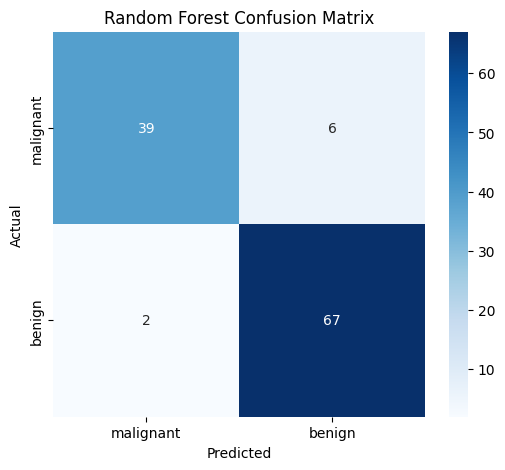

In [18]:
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=data.target_names,
    yticklabels=data.target_names
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest Confusion Matrix")
plt.show()

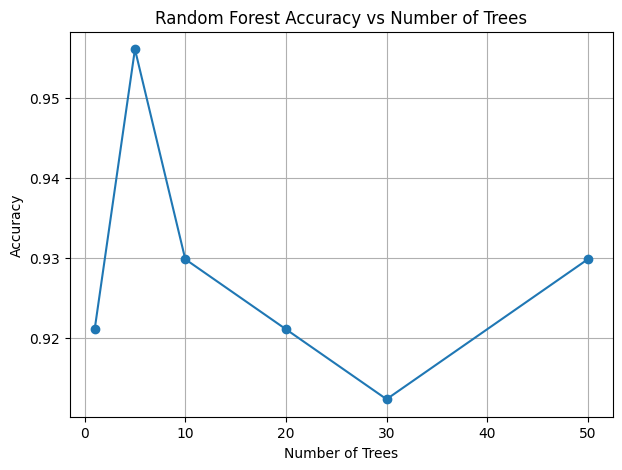

In [19]:
tree_counts = [1, 5, 10, 20, 30, 50]
accuracies = []

for n in tree_counts:
    rf = RandomForest(n_trees=n, max_depth=15)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    accuracies.append(accuracy(y_test, preds))

plt.figure(figsize=(7, 5))
plt.plot(tree_counts, accuracies, marker='o')
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy vs Number of Trees")
plt.grid(True)
plt.show()


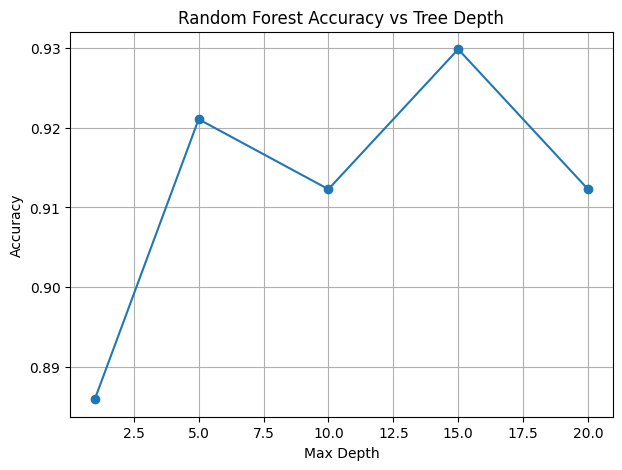

In [22]:
depth_counts = [1, 5, 10, 15, 20]
accuracies = []

for depth in depth_counts:
    rf = RandomForest(n_trees=20, max_depth=depth)
    rf.fit(X_train, y_train)
    preds = rf.predict(X_test)
    accuracies.append(accuracy(y_test, preds))

plt.figure(figsize=(7, 5))
plt.plot(depth_counts, accuracies, marker='o')
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy vs Tree Depth")
plt.grid(True)
plt.show()


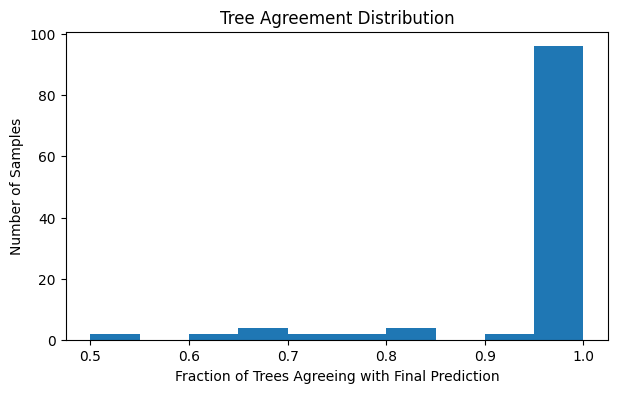

In [20]:
tree_predictions = np.array([tree.predict(X_test) for tree in clf.trees])

agreement = np.mean(tree_predictions == predictions, axis=0)

plt.figure(figsize=(7, 4))
plt.hist(agreement, bins=10)
plt.xlabel("Fraction of Trees Agreeing with Final Prediction")
plt.ylabel("Number of Samples")
plt.title("Tree Agreement Distribution")
plt.show()


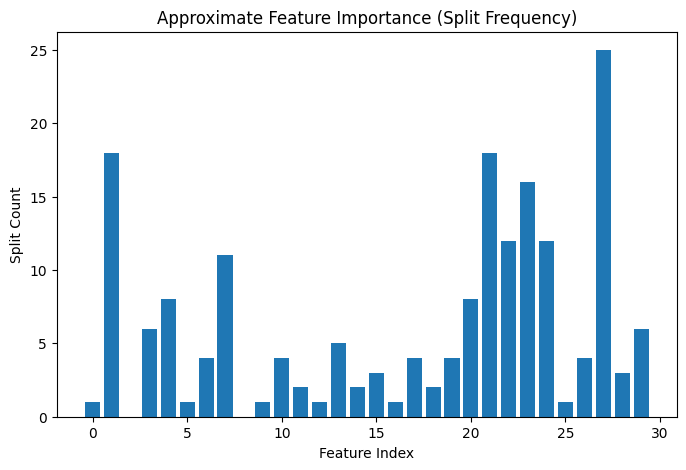

In [21]:
feature_counts = Counter()

def traverse(node):
    if node is None or node.is_leaf_node():
        return
    feature_counts[node.feature] += 1
    traverse(node.left)
    traverse(node.right)

for tree in clf.trees:
    traverse(tree.root)

features = list(feature_counts.keys())
counts = list(feature_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(features, counts)
plt.xlabel("Feature Index")
plt.ylabel("Split Count")
plt.title("Approximate Feature Importance (Split Frequency)")
plt.show()